# Eindopdracht test model 1.2

normalizeer de doelvariabele
kijk naar de metrics


## Inladen Bibliotheek en data 

In [1]:
import torch
from torch import nn, Tensor
import torch.nn.functional 
from torchvision.transforms import functional as F

from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset, Subset
from pipetorch.data import read_from_kaggle, plot_boundaries
from pipetorch.train import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import os
from pathlib import Path  # Import Path from pathlib
from PIL import Image
from sklearn.metrics import r2_score
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import re

from optuna.visualization.matplotlib import plot_slice, plot_contour
from optuna import create_study, TrialPruned




In [2]:
folder = '/datb/BotsNLE/angle90'
folder_path = folder
expanded_folder_path = os.path.expanduser(folder_path)

if os.path.exists(expanded_folder_path):
    print(f"The folder '{expanded_folder_path}' exists.")
else:
    print(f"The folder '{expanded_folder_path}' does not exist.")

The folder '/datb/BotsNLE/angle90' exists.


In [3]:
!ls $folder | head

0000-0.02--0.5625.jpg
0001-0.33--1.6875.jpg
0002-0.62--1.125.jpg
0003-0.91--4.21875.jpg
0004-1.21-3.375.jpg
0005-1.50--3.9374999999999996.jpg
0006-1.81--4.21875.jpg
0007-2.13--1.125.jpg
0008-2.43-2.25.jpg
0009-2.73--3.0937500000000004.jpg
ls: write error: Broken pipe


## Data extraction

In [4]:
def extract_labels(input_path):
    # Extract the filename from the path
    filename = Path(input_path).stem  # Get the filename without the extension
    parts = re.split(r'-(?![^-]-)', filename, maxsplit=2) # Split on '-'
    # print(parts)#

    
    if len(parts) >= 3 and parts[-1]:  # Ensure we have enough parts
        y = float(parts[-1])  # Last part is y2, ensure positive
        return y # Return as a list of two labels
    else:
        print(f"Skipping file (not enough parts to extract labels): {filename}")


In [5]:
# voor het inladen van de afbeedingen in het juiste format
class FileDataset(Dataset):
    def __init__(self, folder, image_size, extension='jpg'):
        super().__init__()
        self.files = list(Path(folder).expanduser().glob(f'*.{extension}'))

        # Transformations to apply to the images
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

        # Lijsten voor afbeeldingen en labels
        self.images = []
        self.labels = []

        # Laad afbeeldingen en labels
        self._load_images_and_labels()
        
        
    def _load_images_and_labels(self):
        for img_path in self.files:
            # Laad de afbeelding
            img = Image.open(img_path).convert('L')  # Open image and convert to grayscale
            
            # Extract the corresponding label for the image using the filename
            y = extract_labels(img_path)
            label = torch.tensor(y, dtype=torch.float32).view(1)  # Ensure label shape is [1]

            if label is None:
                raise ValueError(f"No label found for image: {img_path.name}")
            
            # Apply the transformation (resize, to tensor)
            img = self.transform(img)
            
            # Voeg de originele afbeelding toe
            self.images.append(img)
            self.labels.append(label)
            
            # Maak de flipped afbeelding en voeg deze ook toe
            flipped_img = F.hflip(img)  # Flip image horizontally
            
            # Voeg de flipped afbeelding toe aan de lijst
            self.images.append(flipped_img)
            # Voeg het omgekeerde label toe (negatief label)
            self.labels.append(-label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        # Haal de afbeelding en het bijbehorende label op
        img = self.images[i]
        label = self.labels[i]

        return img, label


In [6]:
# Create the dataset with label data (without the 'extension' argument issue)
image_size = 32
batch_size = 32
ds = FileDataset(folder, image_size, extension='jpg')
len(ds)

1624

In [7]:
dataset_size = len(ds)
train_size = int(0.80 * dataset_size)
valid_size = dataset_size - train_size


train_ds, valid_ds = random_split(ds, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size=batch_size,
                            shuffle=True, num_workers=2)

valid_dl = DataLoader(valid_ds, batch_size=batch_size,
                            shuffle=True, num_workers=2)


In [8]:
ds1 = train_dl.dataset
X, y = ds1[0]
X.shape, y.shape, y, ds1[0]



(torch.Size([1, 32, 32]),
 torch.Size([1]),
 tensor([-31.2188]),
 (tensor([[[0.1059, 0.2235, 0.3961,  ..., 0.1843, 0.1451, 0.1255],
           [0.1216, 0.2745, 0.3922,  ..., 0.1725, 0.1294, 0.0941],
           [0.1490, 0.3176, 0.3765,  ..., 0.1451, 0.0980, 0.0588],
           ...,
           [0.6275, 0.6510, 0.6706,  ..., 0.6353, 0.6157, 0.5882],
           [0.6157, 0.6392, 0.6549,  ..., 0.6314, 0.6078, 0.5804],
           [0.6000, 0.6275, 0.6471,  ..., 0.6235, 0.6000, 0.5647]]]),
  tensor([-31.2188])))

In [9]:
def showx(x):
    plt.imshow(np.transpose(x,(1,2,0)))
    
def demo_batch():
    real_batch = next(iter(train_dl))
    images, labels = real_batch
    remove_upper_half = transforms.Lambda(lambda images: images[:, :, 19:, :])  # Removes upper half, hogere waarden voor x in [:,:,x:,:] betekend een grter deel wat van boven gekropt wordt bij 19 is er nog wel wat ruis in het model maar duidelijk alleen de lijn in beeld
    images = remove_upper_half(images)

    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.title("Training Images")
    showx(vutils.make_grid(images[:24], padding=2, normalize=True))

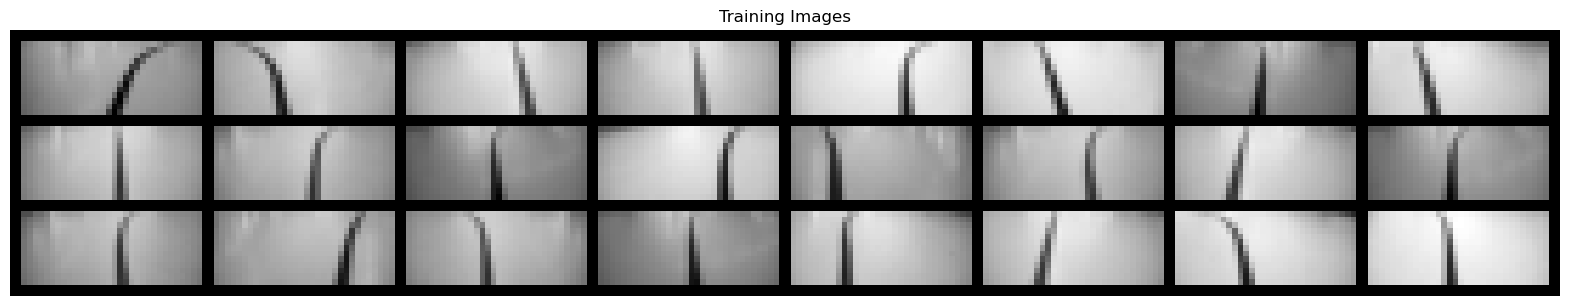

In [10]:
demo_batch()

In [11]:
def Pixel_Mean_Std(data):   
    """
    Calculate the mean and standard deviation for normalization.
    
    Args:
        data (Dataset): The dataset to calculate mean and std for.
        
    Returns:
        tuple: Mean and standard deviation tensors.
    """
    # Create a DataLoader for the dataset with a large batch size to process all data at once
    data_loader = DataLoader(data, batch_size=len(data), shuffle=False)
    
    # Initialize variables to accumulate mean and std
    mean = 0.0
    std = 0.0
    total_samples = 0

    # Iterate through the dataset
    for inputs, _ in data_loader:  # Unpack into inputs (images) and labels (ignored here)
        batch_size = inputs.size(0)
        # Flatten the image dimensions for mean and std calculation
        inputs = inputs.view(batch_size, inputs.size(1), -1)  # Shape: (batch_size, channels, height*width)
        mean += inputs.mean(2).sum(0)  # Mean across spatial dimensions, summed over the batch
        std += inputs.std(2).sum(0)   # Std across spatial dimensions, summed over the batch
        total_samples += batch_size

    # Calculate mean and std across the entire dataset
    mean /= total_samples
    std /= total_samples

    print("Mean:", mean)
    print("Std:", std)
    return mean, std

# Call the function with your dataset
mean, std = Pixel_Mean_Std(ds)


Mean: tensor([0.5603])
Std: tensor([0.1999])


## Baseline Model bouwen

In [12]:
# Data augmentatie
def trans(mean, std):
    return transforms.Normalize(mean, std)

class RemoveUpperHalf(nn.Module):
    def forward(self, img):
        # Remove the upper half of the image (assuming channel-first format)
        return img[:, :, 21:, :]
    
def augment():
        augment = nn.Sequential(
                RemoveUpperHalf(),  # Remove upper half
                transforms.Resize((32, 32), antialias=True),  # Resize to maintain dimensions
                )
        return augment    

def convolutional_layer_image():
    conv = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
    )
    return conv

def conv_layer():
    conv = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
        nn.Flatten(1),
        nn.Linear(32 * 32 * 16, 1)  # Adjust dimensions if needed
    )
    return conv

In [13]:
class Model(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        
        # normalisation
        self.normalize = trans(mean, std)
        
        # augmentation
        self.augment = augment()
        
        # Convolutional layers
        self.conv = conv_layer()
        
        # voor afbeeldingen maken
        self.convolution_image = convolutional_layer_image()
        
        
    def forward(self, X):
        # Normalize the input
        X = self.normalize(X)
        
        # Apply augmentation only during training
        if self.training:
            X = self.augment(X)
            
        # Pass through the convolutional layers
        return self.conv(X)

In [49]:
def augmentation_visualisation_with_conv(Model):
    """
    Visualizes the original, augmented, and convolutional results of an image.
    
    Parameters:
        model: The model containing the augmentation and convolution logic.
        sample_image: A single input image tensor.
    """

    # Instantiate and evaluate the model
    model = Model
    model.eval()  # Ensure the model is in evaluation mode

    # Load a single example from your dataset
    sample_image, _ = next(iter(train_dl))  # Assuming train_dl is your DataLoader
    sample_image = sample_image[:1]  # Take a single image (batch size = 1)

    # Normalize and augment the input
    normalized_image = model.normalize(sample_image)
    augmented_image = model.augment(normalized_image)

    # Extract convolutional features
    conv_output = model.convolution_image(augmented_image)

    # Convert tensors to numpy for visualization
    # Original image
    normal_image = sample_image[0].squeeze().detach().cpu().numpy()

    # Augmented image
    augmented_image_squeezed = augmented_image[0].squeeze().detach().cpu().numpy()

    # Convolutional output (take the first channel)
    conv_output_channel = conv_output[0, 0].detach().cpu().numpy()


    # Plot all three images side by side
    fig, axes = plt.subplots(1, 3)
    
    # Original image
    axes[0].imshow(normal_image, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Augmented image
    axes[1].imshow(augmented_image_squeezed, cmap="gray")
    axes[1].set_title("Augmented Image")
    axes[1].axis("off")

    # Convolutional output
    axes[2].imshow(conv_output_channel, cmap="gray")
    axes[2].set_title("Convolutional Output")
    axes[2].axis("off")

    # Display the plot
    plt.tight_layout()
    plt.show()

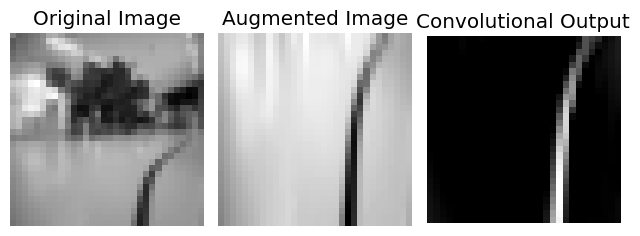

In [50]:
augmentation_visualisation_with_conv(Model(mean, std))

In [16]:
model = Model(mean, std)
model.cuda()

Model(
  (normalize): Normalize(mean=tensor([0.5603]), std=tensor([0.1999]))
  (augment): Sequential(
    (0): RemoveUpperHalf()
    (1): Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
  )
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=16384, out_features=1, bias=True)
  )
  (convolution_image): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
)

In [17]:
t = Trainer(model, 
            loss=nn.MSELoss(), 
            train_dl=train_dl, 
            valid_dl=valid_dl, 
            metrics=R2Score,
            halt_notebook=False) 

  0%|          | 0/40 [00:00<?, ?it/s]

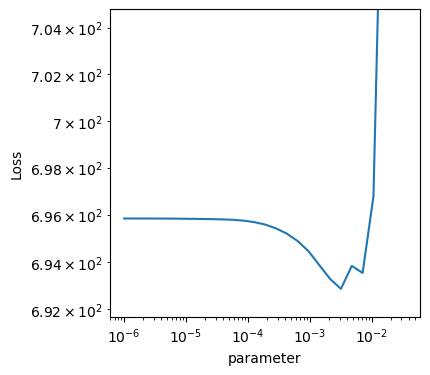

In [18]:
t.lr_find()

In [19]:
t.train(10, lr=(1e-3, 1e-2))

Total:   0%|          | 0/16640 [00:00<?, ?it/s]

Working on cuda:2
 1 1.49s trainloss=204.23650 validloss=1077.51133 R2Score=-0.56352 
 2 0.41s trainloss=53.15538 validloss=994.19568 R2Score=-0.44263 
 3 0.40s trainloss=38.97229 validloss=1003.94292 R2Score=-0.45677 
 4 0.40s trainloss=31.40875 validloss=995.67049 R2Score=-0.44477 
 5 0.39s trainloss=27.06472 validloss=967.80357 R2Score=-0.40433 
 6 0.41s trainloss=24.12349 validloss=949.46208 R2Score=-0.37771 
 7 0.40s trainloss=22.02847 validloss=921.46203 R2Score=-0.33709 
 8 0.43s trainloss=20.69562 validloss=884.18276 R2Score=-0.28299 
 9 0.42s trainloss=19.51294 validloss=853.96830 R2Score=-0.23915 
10 0.41s trainloss=18.51077 validloss=824.50141 R2Score=-0.19639 


In [20]:
def trial(trial):
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    model = Model(mean, std)
    t = Trainer(model, 
                loss=nn.MSELoss(), 
                train_dl=train_dl, 
                valid_dl=valid_dl,
                #metrics=nn.MSELoss(),
                metrics=R2Score,
                halt_notebook=False,
                silent=True) 
    t.train(20, lr=(lr/10, lr), cycle=10)        
    r2 = t.optimum(R2Score)
    #mse = t.optimum(nn.MSELoss())  
    if r2[0] < 0.1:
        raise TrialPruned('r2 too low')
    return r2

study = create_study(direction='maximize')
study.optimize(trial, n_trials=20)
    

[I 2025-01-07 15:01:25,224] A new study created in memory with name: no-name-15e63582-9a59-46ff-ba0f-de9b746fc177
[I 2025-01-07 15:01:32,041] Trial 0 finished with value: 0.14637809991836548 and parameters: {'lr': 0.0019151769330491922}. Best is trial 0 with value: 0.14637809991836548.
[I 2025-01-07 15:01:38,912] Trial 1 pruned. r2 too low
[I 2025-01-07 15:01:45,285] Trial 2 pruned. r2 too low
[I 2025-01-07 15:01:52,508] Trial 3 pruned. r2 too low
[I 2025-01-07 15:01:58,389] Trial 4 pruned. r2 too low
[I 2025-01-07 15:02:04,121] Trial 5 pruned. r2 too low
[I 2025-01-07 15:02:09,950] Trial 6 pruned. r2 too low
[I 2025-01-07 15:02:15,891] Trial 7 pruned. r2 too low
[I 2025-01-07 15:02:21,841] Trial 8 pruned. r2 too low
[I 2025-01-07 15:02:27,883] Trial 9 pruned. r2 too low
[I 2025-01-07 15:02:33,639] Trial 10 finished with value: 0.4715876579284668 and parameters: {'lr': 0.005074466552761228}. Best is trial 10 with value: 0.4715876579284668.
[I 2025-01-07 15:02:39,563] Trial 11 finished 

/tmp/ipykernel_448629/1025440081.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study, target_name='r2')


<Axes: title={'center': 'Slice Plot'}, xlabel='lr', ylabel='r2'>

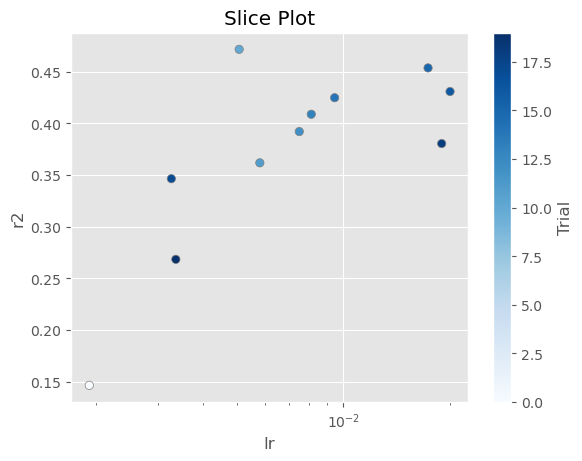

In [21]:
plot_slice(study, target_name='r2')

/tmp/ipykernel_448629/927314822.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2025-01-07 15:03:26,302] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Axes: >

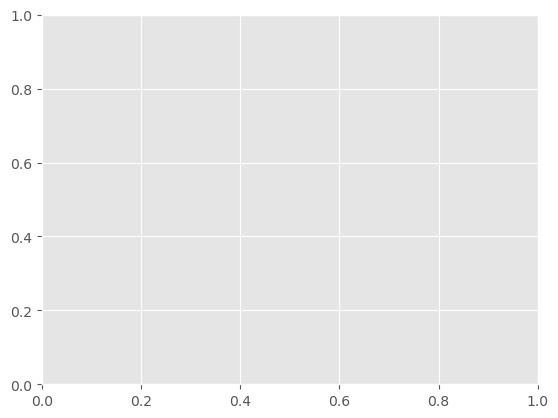

In [22]:
plot_contour(study)

## Augmentatie bepalen

In [98]:
# Data augmentatie
def trans(mean, std):
    return transforms.Normalize(mean, std)

class RemoveUpperHalf(nn.Module):
    def forward(self, img):
        # Remove the upper half of the image (assuming channel-first format)
        return img[:, :, 20:, :]
    
def augment():
        augment = nn.Sequential(
                RemoveUpperHalf(),  # Remove upper half
                transforms.Resize((32, 32), antialias=True),  # Resize to maintain dimensions
                )
        return augment    

def convolutional_layer_image():
    conv = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )
    return conv

def conv_layer():
    conv = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1),
        nn.Flatten(1),
        nn.Linear(32 * 16 * 8, 1)  # Adjust dimensions if needed
    )
    return conv

-----------------volgende set-----------------


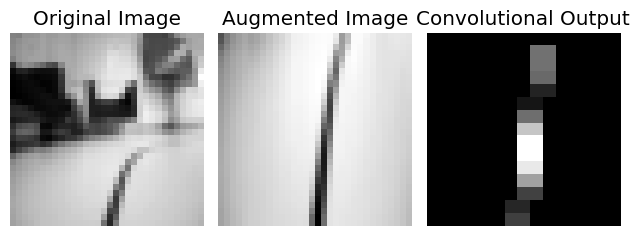

-----------------volgende set-----------------


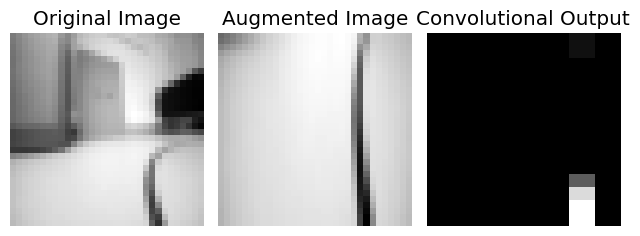

-----------------volgende set-----------------


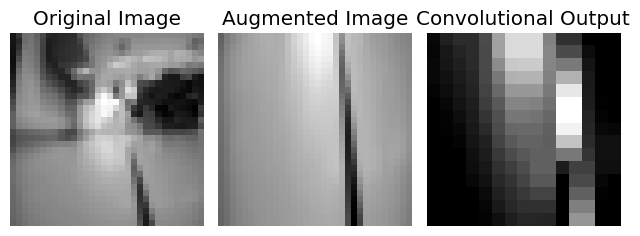

-----------------volgende set-----------------


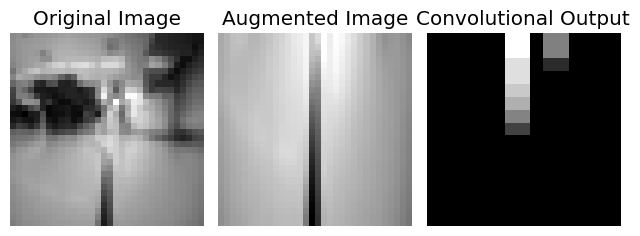

In [99]:
for i in range(4):
    print("-----------------volgende set-----------------")
    augmentation_visualisation_with_conv(Model(mean, std))


In [ ]:
t.lr_find()

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
t.train(10, lr=(1e-4, 1e-3))